In [65]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [66]:
def conv2(img, conv_filter):
    # flip the filter
    f_siz_1, f_size_2 = conv_filter.shape
    conv_filter = conv_filter[range(f_siz_1 - 1, -1, -1), :][:, range(f_siz_1 - 1, -1, -1)]
    pad = (conv_filter.shape[0] - 1) // 2
    result = np.zeros((img.shape))
    img = np.pad(img, ((pad, pad), (pad, pad)), 'constant', constant_values=(0, 0))
    filter_size = conv_filter.shape[0]
    for r in np.arange(img.shape[0] - filter_size + 1):
        for c in np.arange(img.shape[1] - filter_size + 1):
            curr_region = img[r:r + filter_size, c:c + filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)  # Summing the result of multiplication.
            result[r, c] = conv_sum  # Saving the summation in the convolution layer feature map.

    return result

In [67]:
def fspecial(shape=(3, 3), sigma=0.5):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [557]:
# Parameters, add more if needed
sigma = 2
thresh = 0.01

# Derivative masks
dx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
dy = dx.transpose()

rgb = plt.imread('Harris_4.jpg')  # Read in jpg image
bw = rgb[:,:,0] * 0.299 + rgb[:,:,1]*0.587 + rgb[:,:,2] * 0.114 # Convert to grayscale

# computer x and y derivatives of image
Ix = conv2(bw, dx)
Iy = conv2(bw, dy)

rgb.shape

(565, 450, 3)

In [515]:
# Creates a gaussian kernel
g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)

In [516]:
Iy2 = conv2(np.power(Iy, 2), g)
Ix2 = conv2(np.power(Ix, 2), g)
Ixy = conv2(Ix * Iy, g)

In [517]:
######################################################################
# Task: Compute the Harris Cornerness
######################################################################
k = 0.06

def harris_cornerness(Ixy, Ix2, Iy2, k):
     
    det_M = (Ix2 * Iy2) - np.power(Ixy, 2)
    trace_M = Ix2 + Iy2
    
    R = det_M - k * np.power(trace_M, 2)
    
    return R

R = harris_cornerness(Ixy = Ixy,
                       Ix2 = Ix2,
                       Iy2 = Iy2,
                       k = k)

In [518]:
bw.shape

(565, 450)

In [545]:
######################################################################
# Task: Perform non-maximum suppression and
#       thresholding, return the N corner points
#       as an Nx2 matrix of x and y coordinates
######################################################################
def non_maximum_suppression(R, window_sizes, n=5):

    rows, cols = R.shape
    window_r, window_c = window_sizes

    nms = np.zeros(R.shape)

    for i in np.arange(0, rows, window_r):
        for j in range(0, cols, window_c):

            y = R[i:i+window_r, j:j+window_c]

            for ele in y.flatten().argsort()[-n:]:
                nms[i + ele // window_r, j + ele % window_c] = 1

    nms_R = nms * R
    
    return nms_R

def thresholding(nms_R, thresh):
    
    threshold = thresh * nms_R.max()
    x, y = np.where(nms_R > threshold)
    
    corners = np.array([x,y]).T
    
    return corners

nms_R = non_maximum_suppression(R, 1)
corners = thresholding(nms_R, thresh)

TypeError: cannot unpack non-iterable int object

In [ ]:
def inbuilt_harris_corners(image, thresh):
    # Harris Corner Detection using inbuilt functions
#     gray = image[:,:,0] * 0.299 + image[:,:,1]*0.587 + image[:,:,2] * 0.114 # Convert to grayscale    
    gray = np.float32(image)
    corner_R = cv2.cornerHarris(gray,3,13,0.06)

    # Threshold for an optimal value, it may vary depending on the image.
    threshold = thresh * corner_R.max()
    x, y = np.where(corner_R > threshold)
    
    ib_corners = np.array([x,y]).T
    
    return ib_corners

In [ ]:
rgb.shape

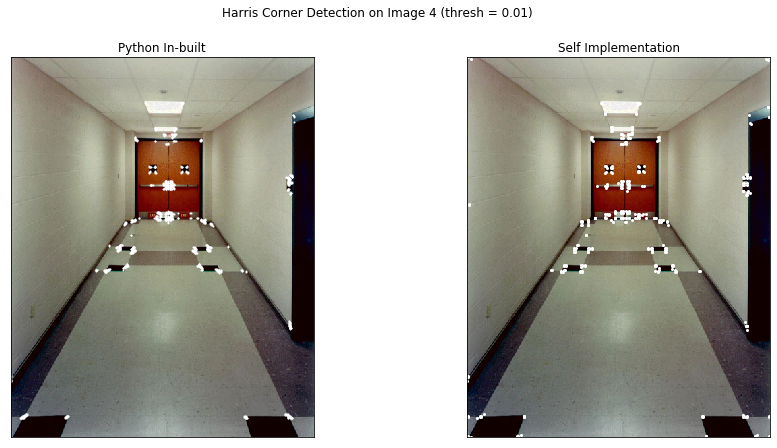

In [531]:
nms_R = non_maximum_suppression(R, 1)
corners = thresholding(nms_R, 0.01)
ib_corners = inbuilt_harris_corners(bw, 0.01)

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(15, 7))

ax1.imshow(rgb, cmap='gray')
ax1.scatter(corners[:,1], corners[:,0], marker = 'o', s=4, c='w')
ax1.set_title("Self Implementation", fontsize=12)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim([565, 0])
ax1.set_xlim([0, 450])
# ax1.set_ylim([476, 0])
# ax1.set_ylim([370,0])

ax2.imshow(rgb, cmap='gray')
ax2.set_title("Python In-built", fontsize=12)
ax2.scatter(ib_corners[:,1], ib_corners[:,0], marker = 'o', s=1, c='w')
ax2.set_xticks([])
ax2.set_yticks([])
# ax2.set_xlim([0, 640])
ax2.set_ylim([565, 0])
ax2.set_xlim([0, 450])


fig.suptitle("Harris Corner Detection on Image 4 (thresh = 0.01)", fontsize= 12)

# fig.tight_layout()
# plt.savefig("Corners4.png")

plt.show()

In [286]:
## Plotting code
thresh = 0.01
si = np.array([3,5,7,9,11,13,15,17,19])
# n = np.ceil(size ** 2 * 0.35)

def plot_corners(thresh, s, n, image=1):
    
    # Parameters, add more if needed
    sigma = 2
#     thresh = 0.01
    k = 0.06

    # Derivative masks
    dx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    dy = dx.transpose()

    bw = plt.imread('Harris_{}.jpg'.format(image))  # Read in jpg image
    if image != 2:
        bw = bw[:,:,0] * 0.299 + bw[:,:,1]*0.587 + bw[:,:,2] * 0.114 # Convert to grayscale

    # computer x and y derivatives of image
    Ix = conv2(bw, dx)
    Iy = conv2(bw, dy)
    
    # Creates a gaussian kernel
    g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)
    
    Iy2 = conv2(np.power(Iy, 2), g)
    Ix2 = conv2(np.power(Ix, 2), g)
    Ixy = conv2(Ix * Iy, g)
    
    R = harris_cornerness(Ixy, Ix2, Iy2, k)
    
    nms_R = non_maximum_suppression(R, s, n)
#     nms_R = R
    
    corners = thresholding(nms_R, thresh)
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    new_bw = bw.copy()
    new_bw[corners[:,0], corners[:,1]] = 255
    
    inbuilt_bw = inbuilt_harris_corners(bw)
    
    fig.suptitle("Corner Detection on Image {}".format(image), fontsize=16)
    ax[0].imshow(bw, cmap='gray')
    ax[0].set_title("Original Image")
    ax[1].imshow(new_bw, cmap='gray')
    ax[1].set_title("My Harris Corner Detection")
    ax[2].imshow(inbuilt_bw, cmap='gray')
    ax[2].set_title("Inbuilt Harris Corner Detection")
    
    
    plt.show()

In [21]:
np.arange(10, 100, 10)

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

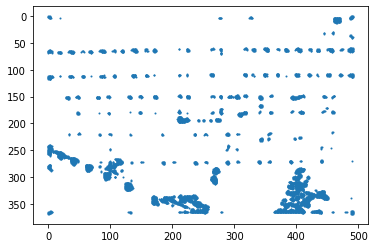

In [64]:
fig, ax = plt.subplots()
ax.scatter(corners[:,1], corners[:,0], marker = 'o', s=1)
ax.invert_yaxis()
# ax.invert_xaxis()

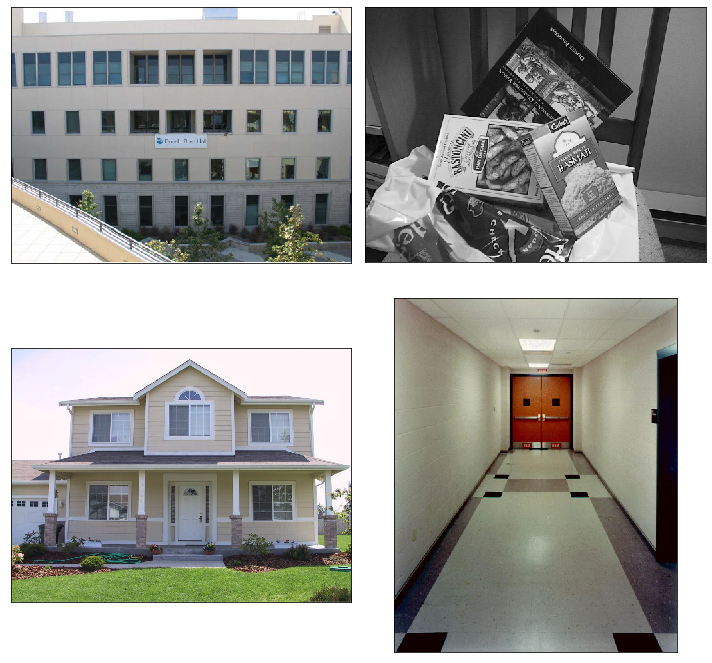

In [537]:
import glob
files = glob.glob("Harris_*")

fig, ax =plt.subplots(2, 2, figsize=(10,10))
for i, img in enumerate(files):
    
    image = plt.imread(img)
    ax[i//2, i%2].imshow(image, cmap='gray')
    ax[i//2, i%2].set_xticks([])
    ax[i//2, i%2].set_yticks([])
    
    
fig.tight_layout() 

In [538]:
s = 3
thresh=0.003
n = 3


print(thresh, "s = {}, n = {}".format(s, n))
plot_corners(thresh, s, int(n), 1)

0.003 s = 3, n = 3


TypeError: non_maximum_suppression() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
for thresh in [0.001, 0.002, 0.003, 0.004]:
    print(thresh)
    plot_corners(thresh, 1)

In [ ]:
plot_corners(1)

In [ ]:
# plot_corners(3)

In [ ]:
# plot_corners(4)

In [ ]:
R.shape

In [ ]:
def non_maximum_suppression(R, size=5, n=4):
    
    rows, cols = R.shape
    padding_size = size // 2 * 2
    
    padded_R = np.zeros((rows + padding_size, cols + padding_size))
    slices = padding_size // 2
    padded_R[slices:-slices, slices:-slices] = R
    
    nms = np.zeros(R.shape)

    for i in range(rows):
        for j in range(cols):

            y = padded_R[i:i+size, j:j+size]

            for ele in y.flatten().argsort()[-n:]:
                nms[i + ele // size - padding_size, j + ele % size - padding_size] = 1
                
    nms_R = nms * R
    
    return nms_R

In [ ]:
plt.imshow(non_maximum_suppression(R, 9, 6))

In [ ]:
padded_R = np.zeros((370 + 4, 492 + 4))
padded_R[2:-2, 2:-2] = R

In [ ]:
yas = 0

nms = np.zeros(R.shape)

for i in range(370):
    for j in range(492):
        
        y = padded_R[i:i+5, j:j+5]
        
#         if y.max() == y[1,1]:
#             nms_R[i, j] = 1

        for ele in y.flatten().argsort()[-4:]:
            nms[i + ele // 5-4, j + ele % 5-4] = 1
            
nms

In [ ]:
plt.imshow((R * nms_R) > 0.01 * R.max())

In [ ]:
y # 4,3,1,0

for ele in np.round(y,0):
    print(ele)

In [ ]:
corners = thresholding(R * nms_R, 0.01)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

new_bw = bw.copy()
new_bw[corners[:,0], corners[:,1]] = 255

inbuilt_bw = inbuilt_harris_corners(bw)

fig.suptitle("Corner Detection on Image 2", fontsize=16)
ax[0].imshow(bw, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(new_bw, cmap='gray')
ax[1].set_title("My Harris Corner Detection")
ax[2].imshow(inbuilt_bw, cmap='gray')
ax[2].set_title("Inbuilt Harris Corner Detection")


plt.show()

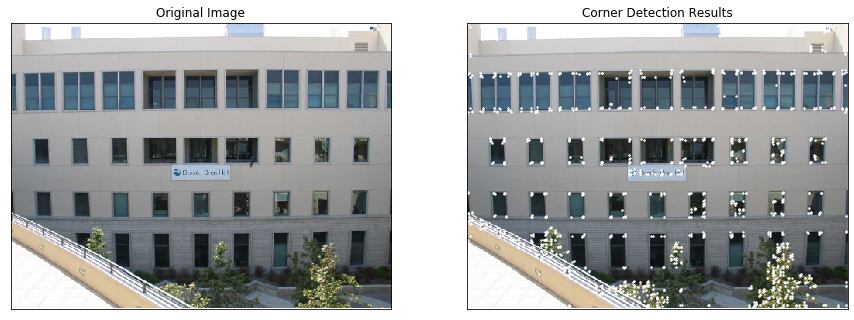

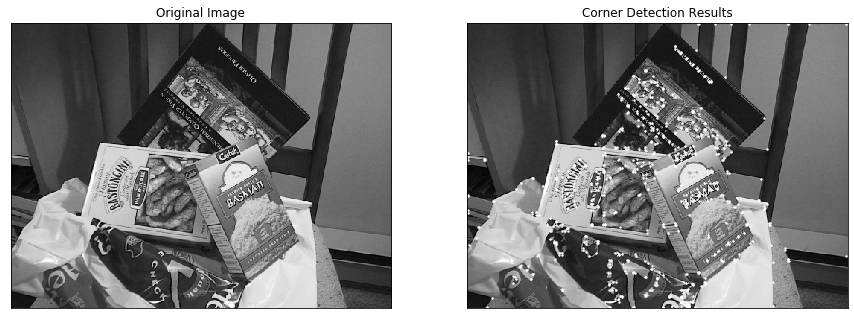

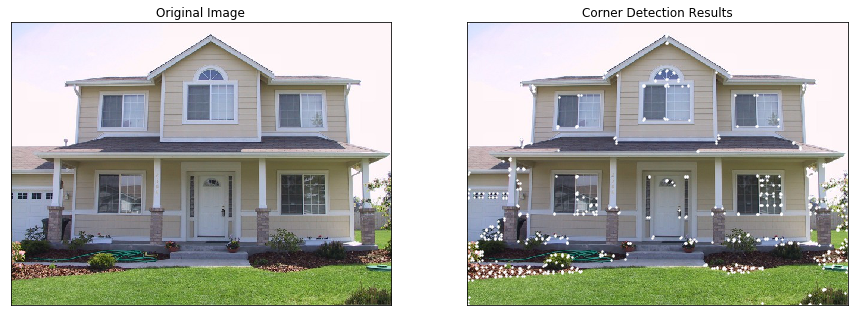

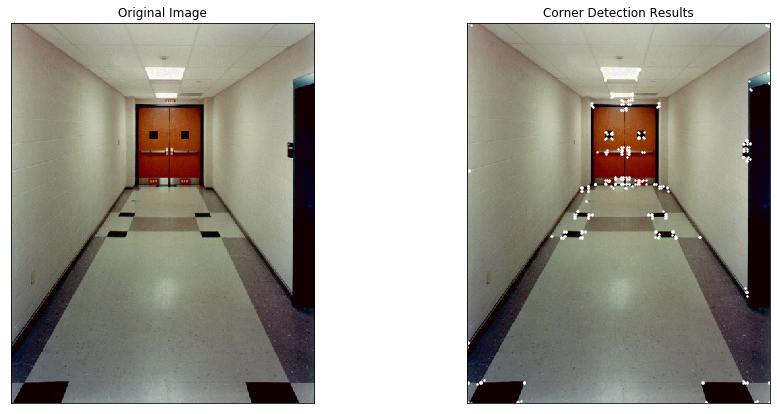

In [553]:
imgs = ['Harris_1.jpg', 'Harris_2.jpg', 'Harris_3.jpg', 'Harris_4.jpg']
window_sizes = [(5, 6), (8, 8), (7, 8), (5, 5)]

for im, ws in zip(imgs, window_sizes):
    
    rgb = plt.imread(im)  # Read in jpg image
    
    if im == 'Harris_2.jpg':
        bw = rgb
    else:
        bw = rgb[:,:,0] * 0.299 + rgb[:,:,1]*0.587 + rgb[:,:,2] * 0.114 # Convert to grayscale
        
    if im == 'Harris_1.jpg':
        thresh = 0.003
    else:
        thresh = 0.01
    
    ylim, xlim = bw.shape
    
#     # computer x and y derivatives of image
    Ix = conv2(bw, dx)
    Iy = conv2(bw, dy)
    
    Iy2 = conv2(np.power(Iy, 2), g)
    Ix2 = conv2(np.power(Ix, 2), g)
    Ixy = conv2(Ix * Iy, g)
    
    R = harris_cornerness(Ixy, Ix2, Iy2, k)
    
    nms_R = non_maximum_suppression(R, ws, 1)
    
    corners = thresholding(nms_R, thresh)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    ax1.imshow(rgb, cmap='gray')
    ax1.set_title("Original Image", fontsize=12)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2.imshow(rgb, cmap='gray')
    ax2.scatter(corners[:,1], corners[:,0], marker = 'o', s=2, c='w')
    ax2.set_title("Corner Detection Results", fontsize=12)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlim([0, xlim])
    ax2.set_ylim([ylim, 0])
    
    fig.savefig((im + ".results.png"))
    
    plt.show()